In [1]:
import numpy as np
import pandas as pd
import jax.numpy as jnp
import matplotlib.pyplot as plt
import seaborn as sns
from aging.behavior.bio_age_model import fit_model, masked_xval, stratified_xval
from aging.plotting import (
    figure,
    format_plots,
    add_identity,
    legend,
    PlotConfig,
    save_factory,
)
from sklearn.preprocessing import OneHotEncoder
from tqdm.auto import tqdm
from itertools import product
from toolz import valmap, keyfilter, pluck, reduce

import colorcet as cc
from sklearn.preprocessing import LabelEncoder

from operator import or_

from aging.behavior.bio_age_model import model_fun_v5, get_biological_age
from toolz import dissoc

from aging.behavior.bio_age_model import (
    model_setup,
    model_fun_v2,
    compute_concentrations,
    expected_counts,
    concentration_interpolation,
    create_masks,
    compute_heldout_r2,
)
from sklearn.metrics import r2_score
from pathlib import Path

import joblib
from toolz import drop
import random

In [2]:
format_plots()

In [3]:
def zscore(ser: pd.Series):
    return (ser - ser.mean()) / ser.std()


def demean(ser: pd.Series):
    return ser - ser.mean()


def quantile(n):
    def percentile_(x):
        return x.quantile(n)

    percentile_.__name__ = "q_{:0.02f}".format(n)
    return percentile_


def read_male_ontogeny(use_syllables=None):
    df = pd.read_parquet(
        "/n/groups/datta/win/longtogeny/data/ontogeny/version_11/ontogeny_males_relabeled_counts_matrix_v00.parquet"
    )
    df = df.sort_index(axis=1)
    df = df.query("age < 100")

    pth = "/n/groups/datta/win/longtogeny/data/ontogeny/version_11/ontogeny_males_mouse_area_df_v00.parquet"
    size_df = pd.read_parquet(pth)

    sizes_col = zscore(size_df.groupby("age")["quant_0.5"].transform(demean))
    sizes_col = sizes_col.loc[df.index]
    df = df.loc[sizes_col.index]

    if use_syllables is None:
        avg_age_usages = df.groupby("age", observed=True).mean()
        syll_mask = (avg_age_usages.var() > 15) & (avg_age_usages.quantile(0.95) > 20)
        print(syll_mask.sum(), "syllables")

        df = df.loc[:, syll_mask]

        male_sylls = syll_mask.index[syll_mask]
    else:
        df = df[use_syllables]
        male_sylls = None
    return df, sizes_col, male_sylls

In [4]:
df, sizes_col, male_sylls = read_male_ontogeny()
age = jnp.array(df.index.get_level_values("age"))
syllable_counts_jax = jnp.array(df.astype(float))

56 syllables


In [37]:
features = {
    "ages": age,
    "counts": syllable_counts_jax + 1,
    "sizes": sizes_col.to_numpy(),
}

hypparams = {
    "min_age": 1,
    "max_age": 100,
    "age_sd": 9,  # weeks
    # "bio_params_sd": 3,
    "size_params_sd": 1000,
    "n_age_samples": 1000,
    "n_splines": 4,
    "n_size_splines": 5,
    "n_syllables": syllable_counts_jax.shape[1],
    "n_keep_sylls": 25,
    "n_sessions": len(syllable_counts_jax),
    "lr": 0.1,
    "n_opt_iter": 200,
    "use_rw_prior": False,
    "rw_sd": 100
}

In [6]:
out = []
for _age_sd in tqdm(np.linspace(1, 50, 25)):
    hypparams["age_sd"] = float(_age_sd)
    tmp = masked_xval(features, hypparams, 2, n_repeats=5, disable_tqdm=True)
    tmp["grid_params"] = keyfilter(
        lambda k: k in ["n_splines", "age_sd"], hypparams
    )
    heldout_ll = list(
        pluck("heldout_ll", keyfilter(lambda k: isinstance(k, int), tmp).values())
    )
    heldout_ll = np.mean(heldout_ll)
    heldout_r2 = list(
        pluck(
            "heldout_r2_total_v3", keyfilter(lambda k: isinstance(k, int), tmp).values()
        )
    )
    heldout_r2 = np.mean(heldout_r2)
    param_norm = np.mean(
        [
            np.linalg.norm(v["params"]["bio_basis_weights"], axis=1).mean()
            for v in keyfilter(lambda k: isinstance(k, int), tmp).values()
        ]
    )
    out.append(
        {
            **tmp["grid_params"],
            "param_norm": param_norm,
            "heldout_ll": heldout_ll,
            "heldout_r2": heldout_r2,
        }
    )
out = pd.DataFrame(out)

  0%|          | 0/25 [00:00<?, ?it/s]

In [8]:
out.set_index('age_sd')

,n_splines,param_norm,heldout_ll,heldout_r2
age_sd,,,,
1.000000,4,3.182111,-393361.6,0.274478
3.041667,4,3.870939,-393180.4,0.357949
5.083333,4,5.987051,-392626.0,0.514869
7.125000,4,5.918052,-392391.0,0.523387
9.166667,4,4.755352,-392625.8,0.505724
11.208333,4,4.321378,-392534.4,0.509645
13.250000,4,4.212718,-392463.0,0.512652
15.291667,4,4.126718,-392424.0,0.514642
17.333333,4,4.051614,-392399.8,0.516143


<Axes: xlabel='age_sd'>

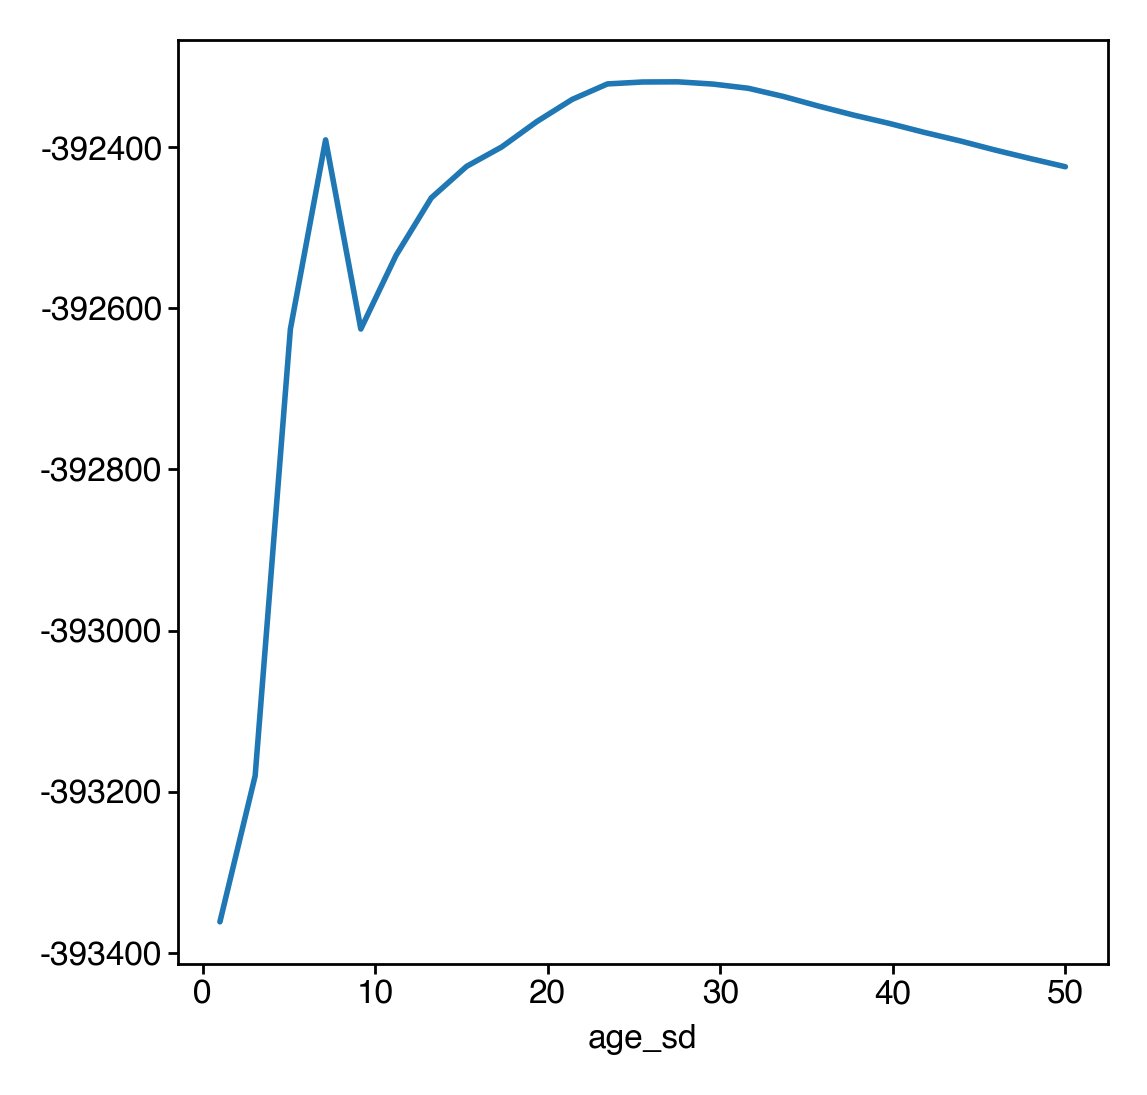

In [10]:
out.set_index('age_sd')['heldout_ll'].plot()

<Axes: xlabel='age_sd'>

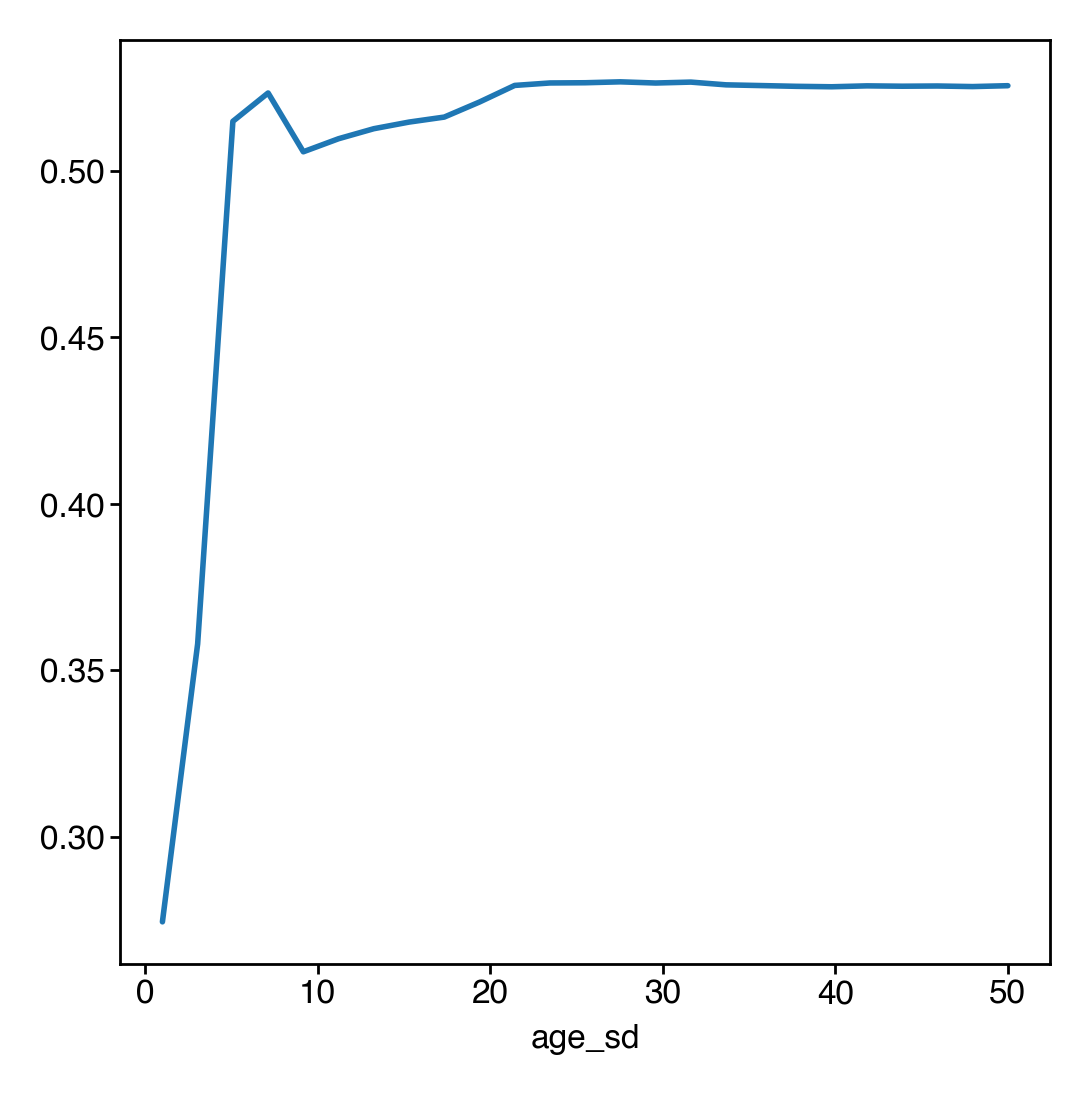

In [11]:
out.set_index('age_sd')['heldout_r2'].plot()

In [82]:
out = []
for _age_sd in tqdm(np.linspace(4, 16, 16)):
    hypparams["age_sd"] = float(_age_sd)
    tmp = masked_xval(features, hypparams, 2, n_repeats=3, disable_tqdm=True)
    tmp["grid_params"] = keyfilter(
        lambda k: k in ["n_splines", "age_sd"], hypparams
    )
    heldout_ll = list(
        pluck("heldout_ll", keyfilter(lambda k: isinstance(k, int), tmp).values())
    )
    heldout_ll = np.mean(heldout_ll)
    heldout_r2 = list(
        pluck(
            "heldout_r2_total_v3", keyfilter(lambda k: isinstance(k, int), tmp).values()
        )
    )
    heldout_r2 = np.mean(heldout_r2)
    param_norm = np.mean(
        [
            np.linalg.norm(v["params"]["bio_basis_weights"], axis=1).mean()
            for v in keyfilter(lambda k: isinstance(k, int), tmp).values()
        ]
    )
    out.append(
        {
            **tmp["grid_params"],
            "param_norm": param_norm,
            "heldout_ll": heldout_ll,
            "heldout_r2": heldout_r2,
        }
    )
out = pd.DataFrame(out)

  0%|          | 0/16 [00:00<?, ?it/s]

<Axes: xlabel='age_sd'>

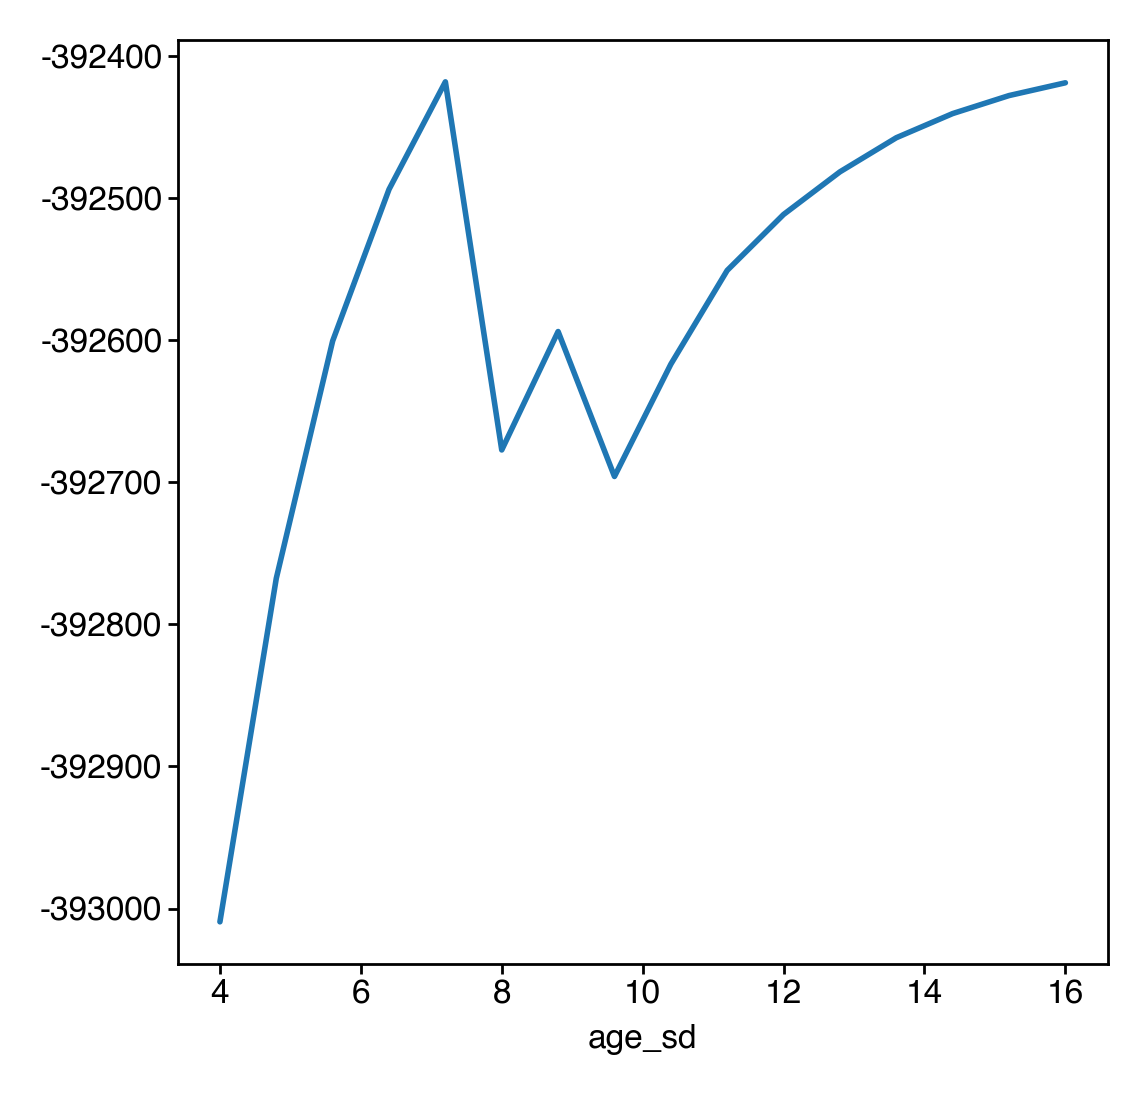

In [83]:
out.set_index('age_sd')['heldout_ll'].plot()

In [85]:
out.sort_values(by='heldout_ll', ascending=False)

,age_sd,n_splines,param_norm,heldout_ll,heldout_r2
4,7.2,4,4.937376,-392418.333333,0.515843
15,16.0,4,3.911478,-392419.000000,0.514049
14,15.2,4,3.918328,-392428.000000,0.514612
13,14.4,4,3.928801,-392440.666667,0.513481
12,13.6,4,3.944293,-392457.666667,0.512295
11,12.8,4,3.957249,-392481.666667,0.511598
3,6.4,4,4.984331,-392494.000000,0.512656
10,12.0,4,3.968143,-392511.666667,0.510747
9,11.2,4,3.970819,-392551.000000,0.509304
6,8.8,4,4.256612,-392594.000000,0.511254


In [18]:
out = []

# losses = {}

hypparams["age_sd"] = 7.0

for n_splines in tqdm(range(4, 50, 5)):
    try:
        hypparams["n_splines"] = n_splines
        tmp = masked_xval(features, hypparams, 2, n_repeats=2, disable_tqdm=True)
        # losses[n_splines] = tmp[0]["loss"]
        tmp["grid_params"] = keyfilter(
            lambda k: k in ["n_splines", "age_sd"], hypparams
        )
        heldout_ll = list(
            pluck("heldout_ll", keyfilter(lambda k: isinstance(k, int), tmp).values())
        )
        heldout_ll = np.mean(heldout_ll)
        heldout_r2 = list(
            pluck(
                "heldout_r2_total_v3",
                keyfilter(lambda k: isinstance(k, int), tmp).values(),
            )
        )
        heldout_r2 = np.mean(heldout_r2)
        param_norm = np.mean(
            [
                np.linalg.norm(v["params"]["bio_basis_weights"], axis=1).mean()
                for v in keyfilter(lambda k: isinstance(k, int), tmp).values()
            ]
        )
        out.append(
            {
                **tmp["grid_params"],
                "param_norm": param_norm,
                "heldout_ll": heldout_ll,
                "heldout_r2": heldout_r2,
            }
        )
    except ValueError:
        continue

out = pd.DataFrame(out)

  0%|          | 0/10 [00:00<?, ?it/s]

In [13]:
out = pd.DataFrame(out)

<Axes: xlabel='n_splines'>

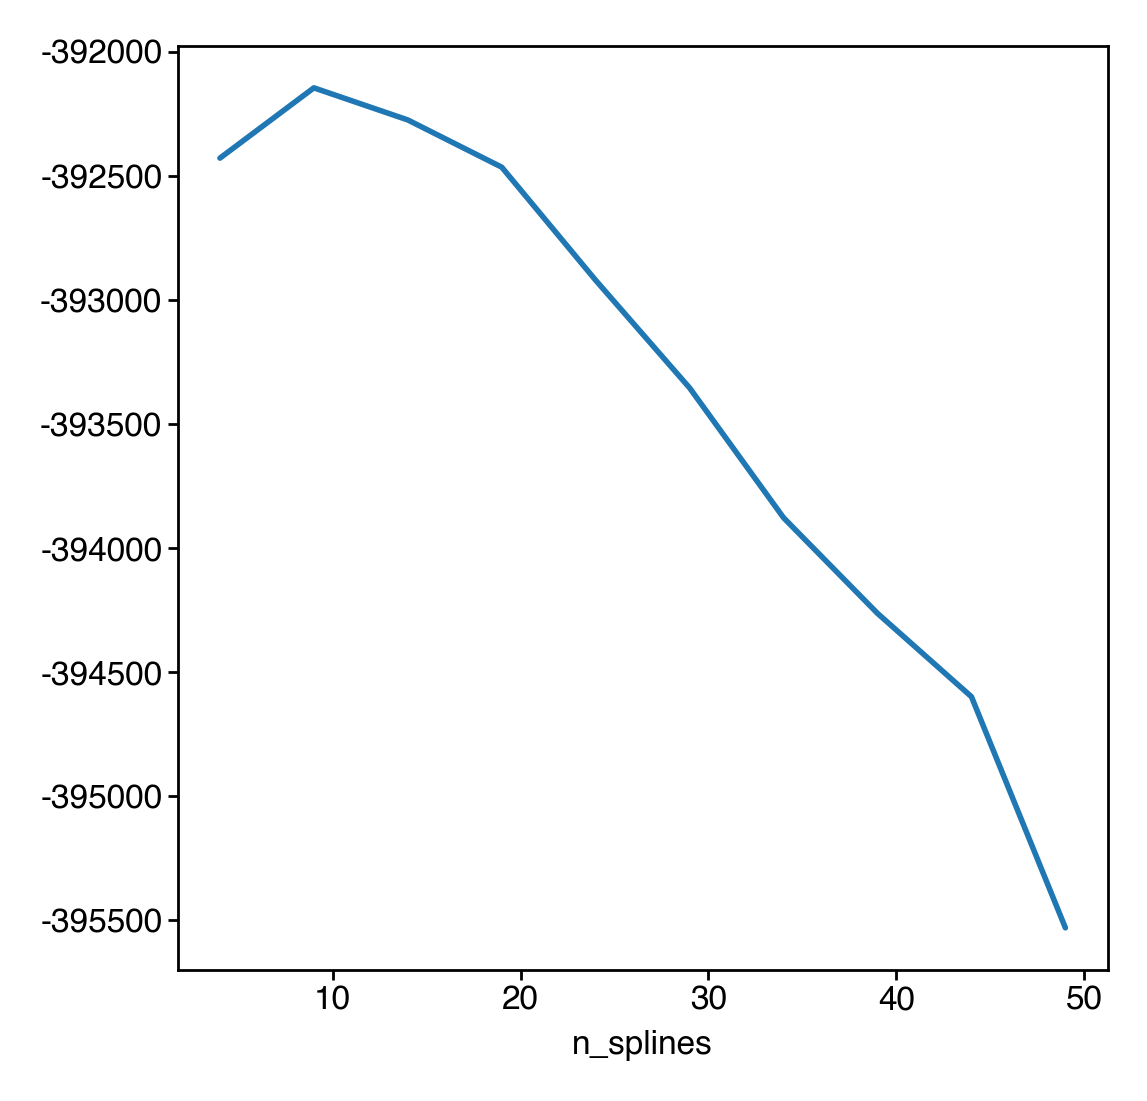

In [19]:
out.set_index('n_splines')['heldout_ll'].plot()

<Axes: xlabel='n_splines'>

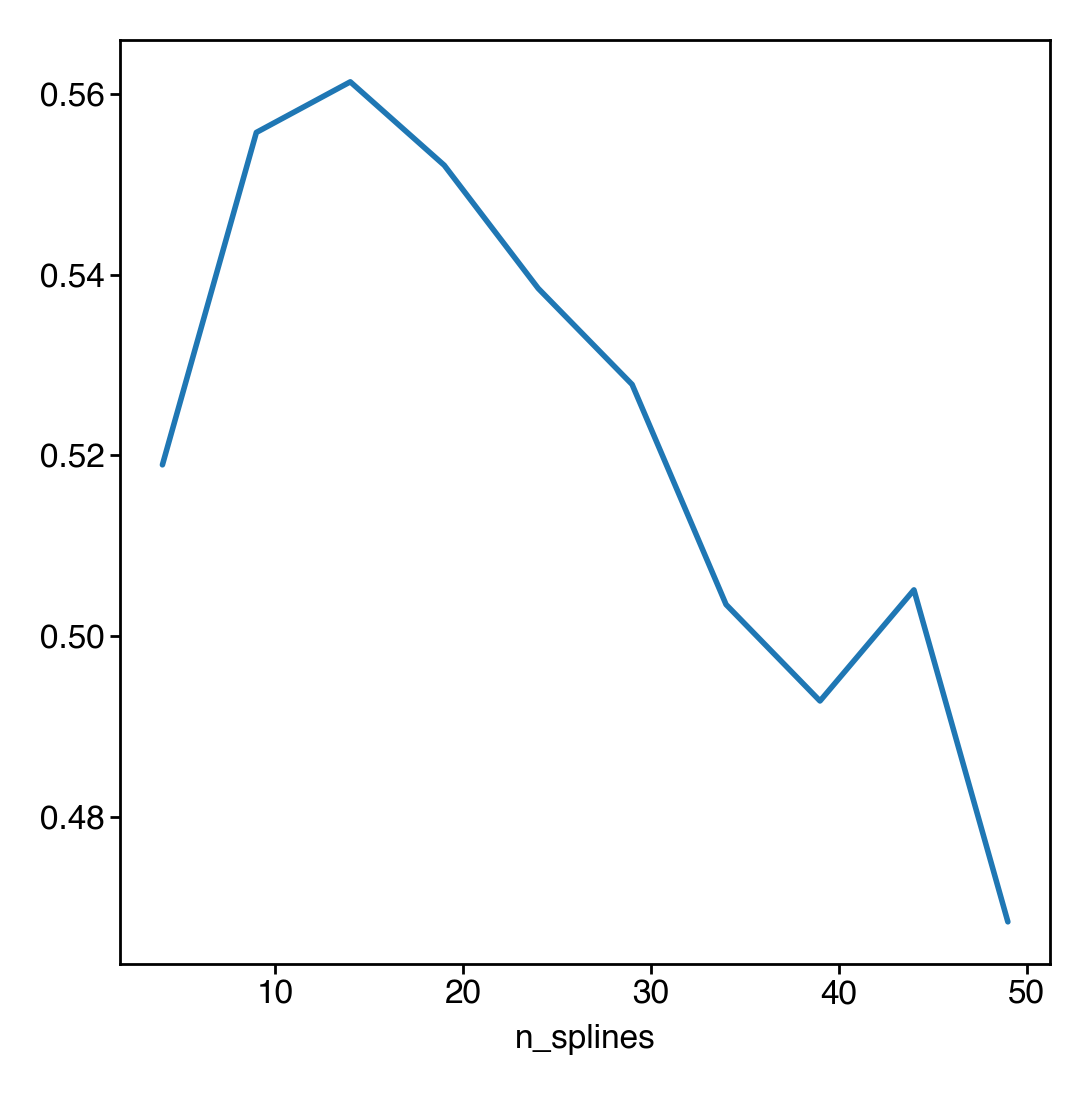

In [20]:
out.set_index('n_splines')['heldout_r2'].plot()

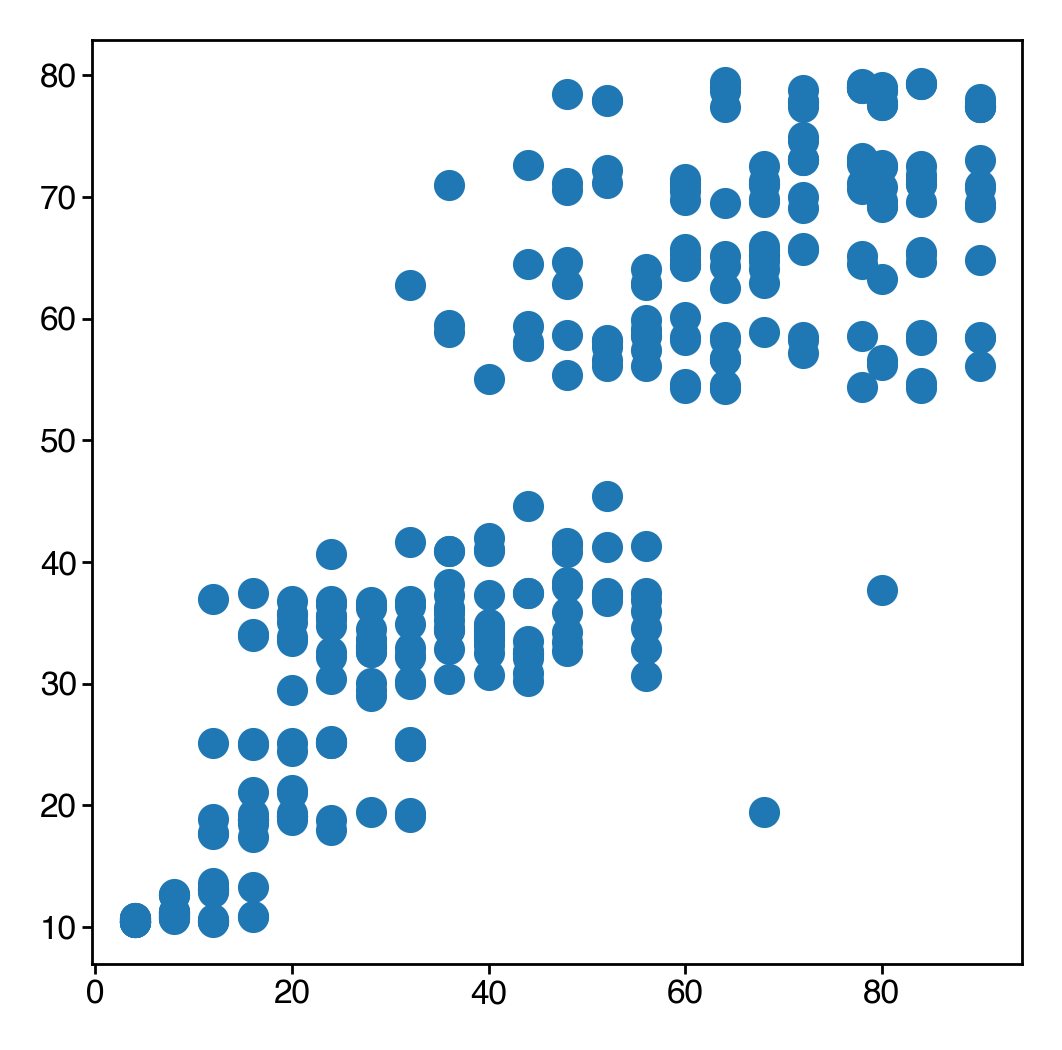

In [23]:
plt.scatter(tmp[0]['true_ages'], tmp[0]['bio_ages'])

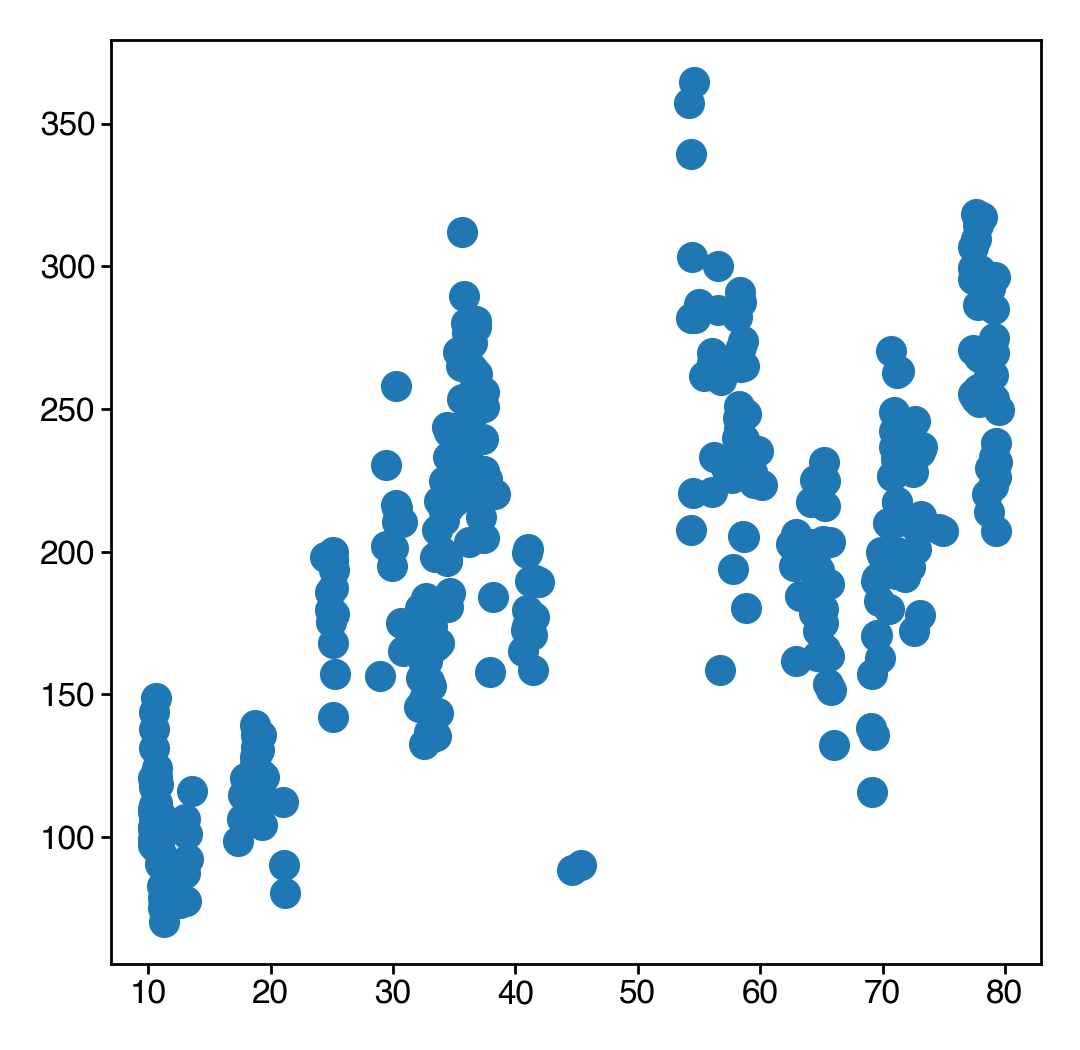

In [24]:
plt.scatter(tmp[0]['bio_ages'], tmp[0]['predicted_counts'][:, 0])

In [25]:
out = []

# losses = {}

hypparams["age_sd"] = 7.0

for n_splines in tqdm(range(6, 14, 1)):
    try:
        hypparams["n_splines"] = n_splines
        tmp = masked_xval(features, hypparams, 2, n_repeats=2, disable_tqdm=True)
        # losses[n_splines] = tmp[0]["loss"]
        tmp["grid_params"] = keyfilter(
            lambda k: k in ["n_splines", "age_sd"], hypparams
        )
        heldout_ll = list(
            pluck("heldout_ll", keyfilter(lambda k: isinstance(k, int), tmp).values())
        )
        heldout_ll = np.mean(heldout_ll)
        heldout_r2 = list(
            pluck(
                "heldout_r2_total_v3",
                keyfilter(lambda k: isinstance(k, int), tmp).values(),
            )
        )
        heldout_r2 = np.mean(heldout_r2)
        param_norm = np.mean(
            [
                np.linalg.norm(v["params"]["bio_basis_weights"], axis=1).mean()
                for v in keyfilter(lambda k: isinstance(k, int), tmp).values()
            ]
        )
        out.append(
            {
                **tmp["grid_params"],
                "param_norm": param_norm,
                "heldout_ll": heldout_ll,
                "heldout_r2": heldout_r2,
            }
        )
    except ValueError:
        continue

out = pd.DataFrame(out)

  0%|          | 0/8 [00:00<?, ?it/s]

<Axes: xlabel='n_splines'>

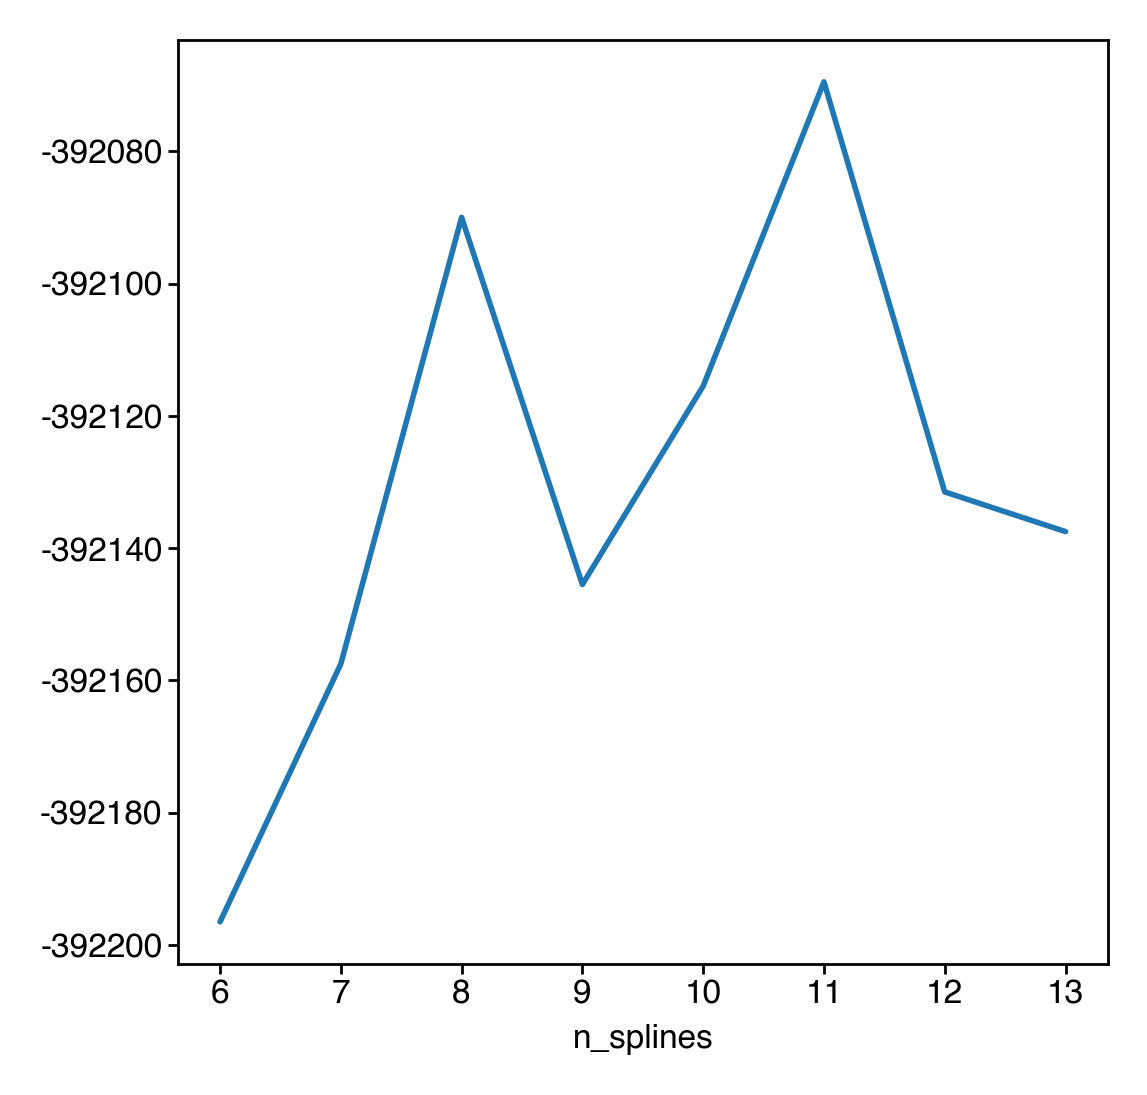

In [26]:
out.set_index('n_splines')['heldout_ll'].plot()

<Axes: xlabel='n_splines'>

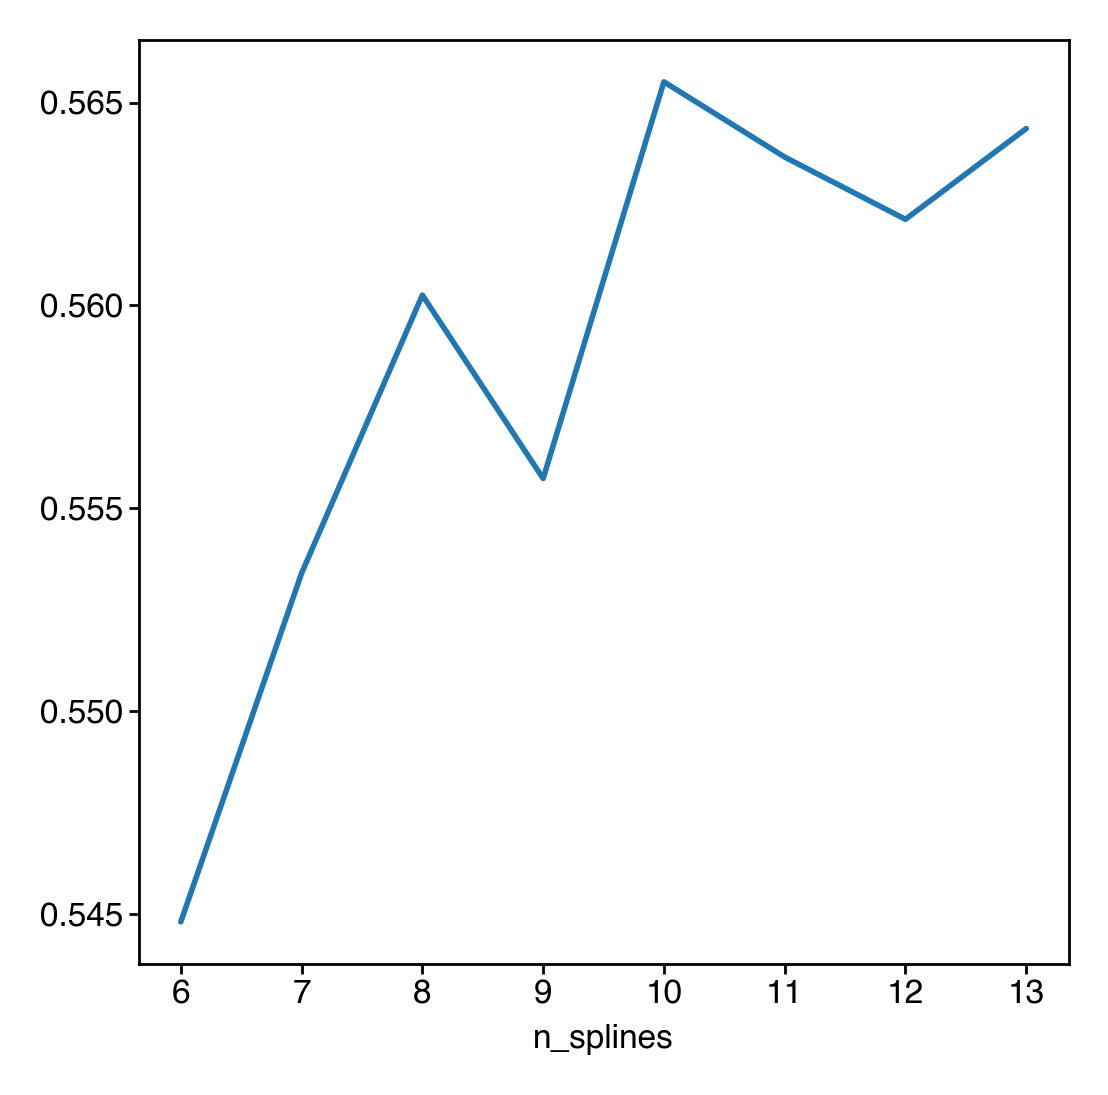

In [27]:
out.set_index('n_splines')['heldout_r2'].plot()

In [ ]:
hypparams['n_splines'] = 11
tmp = masked_xval(features, hypparams, 2, n_repeats=2, disable_tqdm=True)


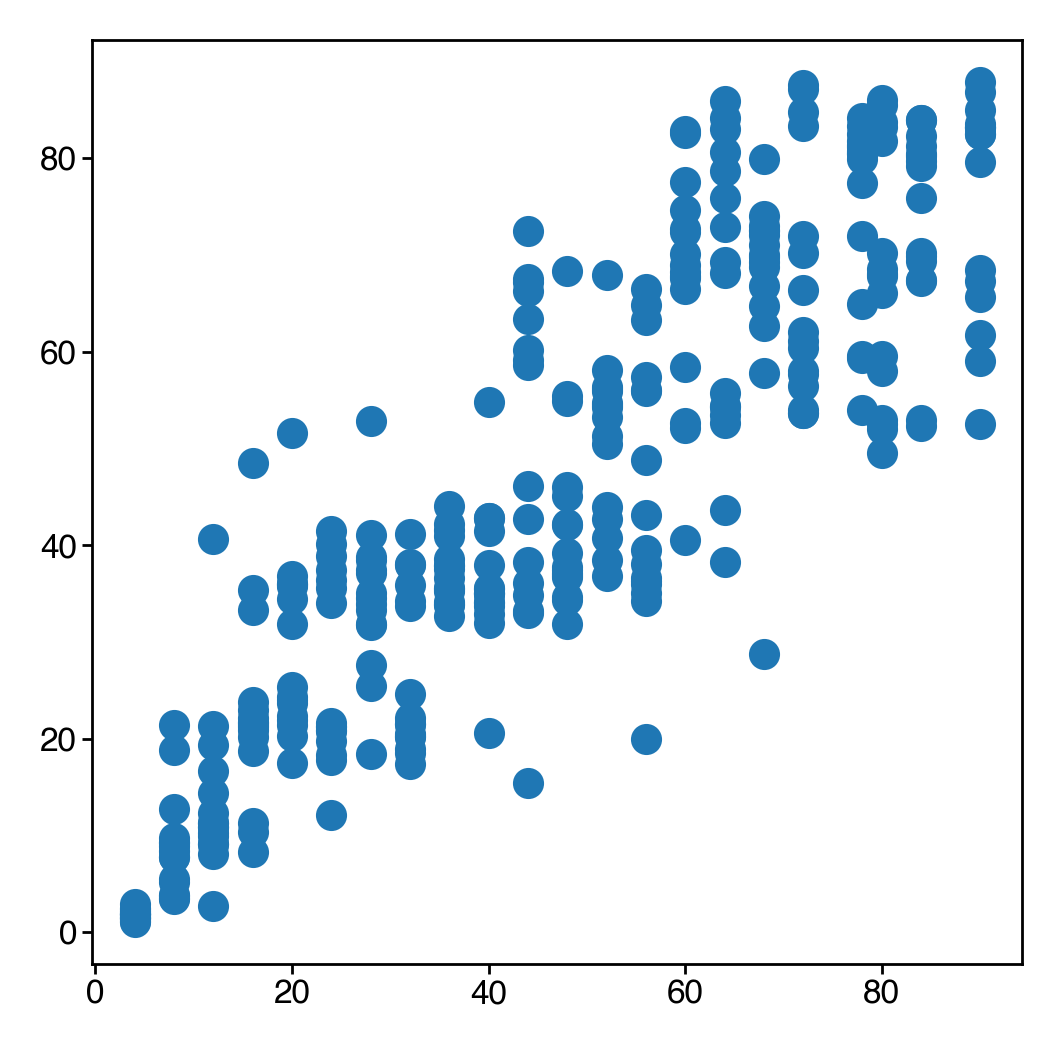

In [31]:
plt.scatter(tmp[0]['true_ages'], tmp[0]['bio_ages'])

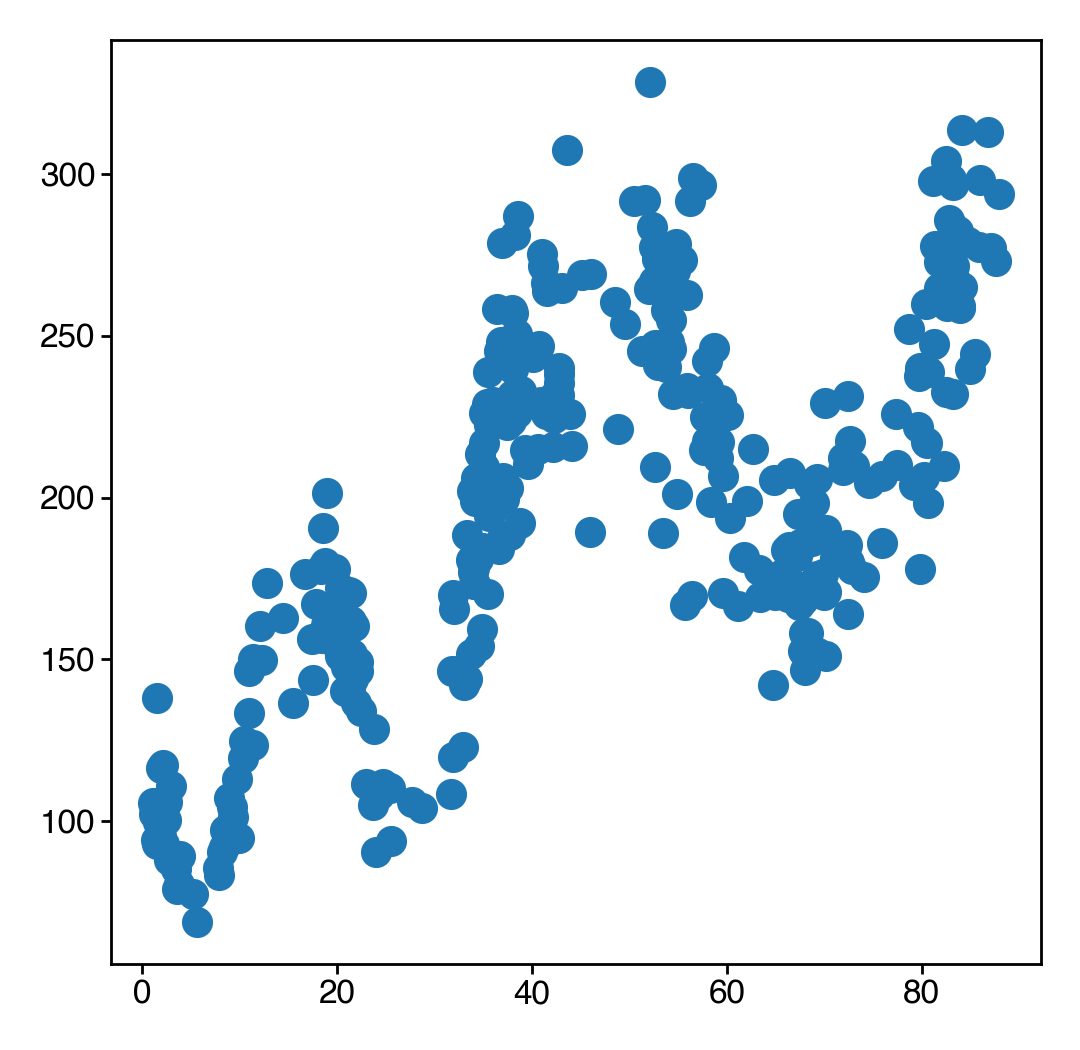

In [32]:
plt.scatter(tmp[0]['bio_ages'], tmp[0]['predicted_counts'][:, 0])

## Try splitting the data into smaller sizes - what happens to the held-out spline optimization? Does it increase?

In [55]:
from sklearn.model_selection import StratifiedKFold
from toolz import first, take

In [65]:
folds = [1/3, 2, 5, 16]

hypparams = {
    "min_age": 1,
    "max_age": 100,
    "age_sd": 7,  # weeks
    # "bio_params_sd": 3,
    "size_params_sd": 1000,
    "n_age_samples": 1000,
    "n_splines": 4,
    "n_size_splines": 5,
    "n_syllables": syllable_counts_jax.shape[1],
    "n_keep_sylls": 25,
    # "n_sessions": len(train),
    "lr": 0.1,
    "n_opt_iter": 125,
    "use_rw_prior": False,
    "rw_sd": 100,
}
out = []

for fold in tqdm(folds[::-1], desc="Looping through folds"):
    new_fold = fold if fold > 1 else int(1 / fold)
    for fold_num, (train, test) in enumerate(take(2, StratifiedKFold(new_fold, shuffle=True, random_state=0).split(age, age))):
        if fold < 1:
            train, test = test, train

        features = {
            "ages": age[train],
            "counts": syllable_counts_jax[train] + 1,
            "sizes": sizes_col.to_numpy()[train],
        }
        hypparams["n_sessions"] = len(train)
    
        for n_splines in tqdm(range(4, 12, 2), desc="Looping through splines"):
            try:
                hypparams["n_splines"] = n_splines
                tmp = masked_xval(features, hypparams, 2, n_repeats=2, disable_tqdm=True)
                tmp["grid_params"] = keyfilter(
                    lambda k: k in ["n_splines", "age_sd"], hypparams
                )
                heldout_ll = list(
                    pluck(
                        "heldout_ll", keyfilter(lambda k: isinstance(k, int), tmp).values()
                    )
                )
                heldout_ll = np.mean(heldout_ll) / len(train)
                heldout_r2 = list(
                    pluck(
                        "heldout_r2_total_v3",
                        keyfilter(lambda k: isinstance(k, int), tmp).values(),
                    )
                )
                heldout_r2 = np.mean(heldout_r2)
                param_norm = np.mean(
                    [
                        np.linalg.norm(v["params"]["bio_basis_weights"], axis=1).mean()
                        for v in keyfilter(lambda k: isinstance(k, int), tmp).values()
                    ]
                )
                out.append(
                    {
                        **tmp["grid_params"],
                        "param_norm": param_norm,
                        "heldout_ll": heldout_ll,
                        "heldout_r2": heldout_r2,
                        "n_folds": fold,
                        "fold_num": fold_num,
                    }
                )
            except ValueError:
                continue
    
print(
    pd.DataFrame(out).groupby(['n_folds', 'n_splines'])[['heldout_ll']].mean().groupby("n_folds")["heldout_ll"].idxmax()
)

Looping through folds:   0%|          | 0/4 [00:00<?, ?it/s]

/home/wg41/miniconda3/envs/aging-gpu/lib/python3.10/site-packages/sklearn/model_selection/_split.py:737: UserWarning: The least populated class in y has only 15 members, which is less than n_splits=16.
  warnings.warn(


Looping through splines:   0%|          | 0/4 [00:00<?, ?it/s]

Looping through splines:   0%|          | 0/4 [00:00<?, ?it/s]

Looping through splines:   0%|          | 0/4 [00:00<?, ?it/s]

Looping through splines:   0%|          | 0/4 [00:00<?, ?it/s]

Looping through splines:   0%|          | 0/4 [00:00<?, ?it/s]

Looping through splines:   0%|          | 0/4 [00:00<?, ?it/s]

Looping through splines:   0%|          | 0/4 [00:00<?, ?it/s]

Looping through splines:   0%|          | 0/4 [00:00<?, ?it/s]

n_folds
0.333333     (0.3333333333333333, 6)
2.000000                    (2.0, 6)
5.000000                    (5.0, 8)
16.000000                 (16.0, 10)
Name: heldout_ll, dtype: object


In [66]:
out = pd.DataFrame(out)

[Text(0, 0.5, 'Heldout LL')]

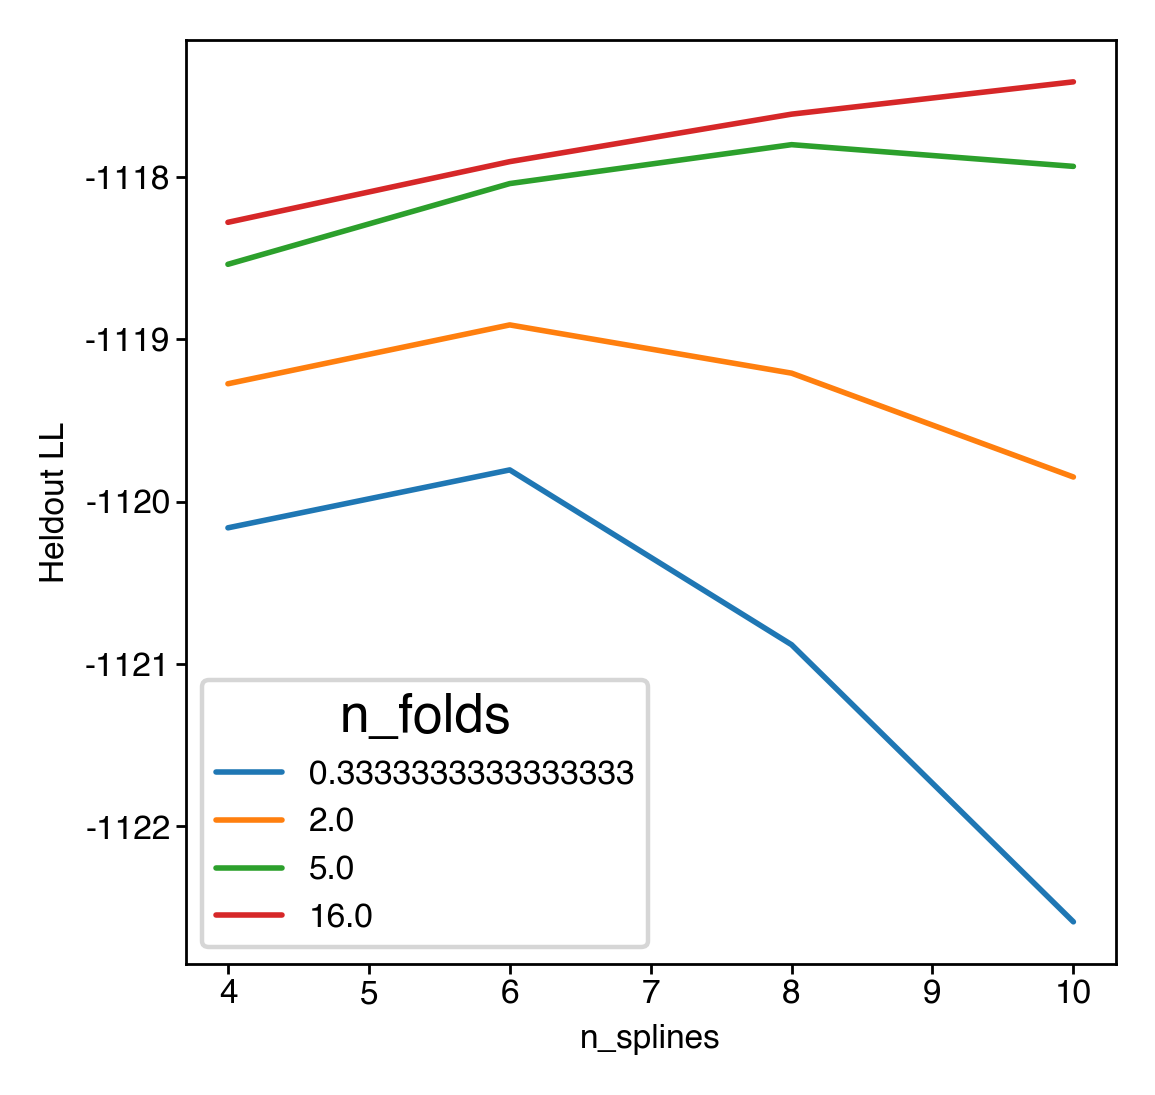

In [80]:
ax = pd.pivot_table(out, columns='n_folds', index='n_splines', values='heldout_ll').plot()
ax.set(ylabel='Heldout LL')

<Axes: xlabel='n_splines'>

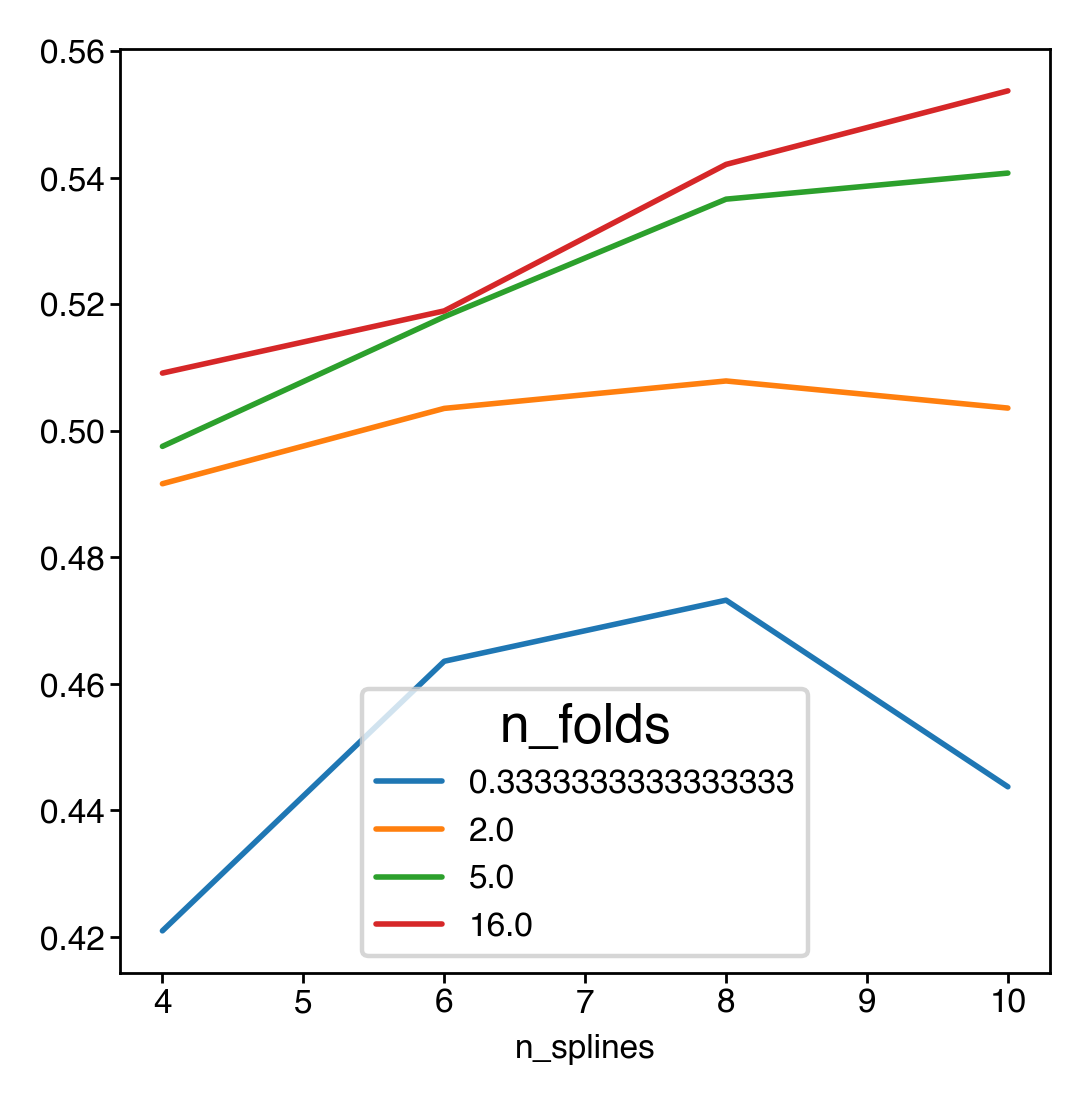

In [69]:
pd.pivot_table(out, columns='n_folds', index='n_splines', values='heldout_r2').plot()

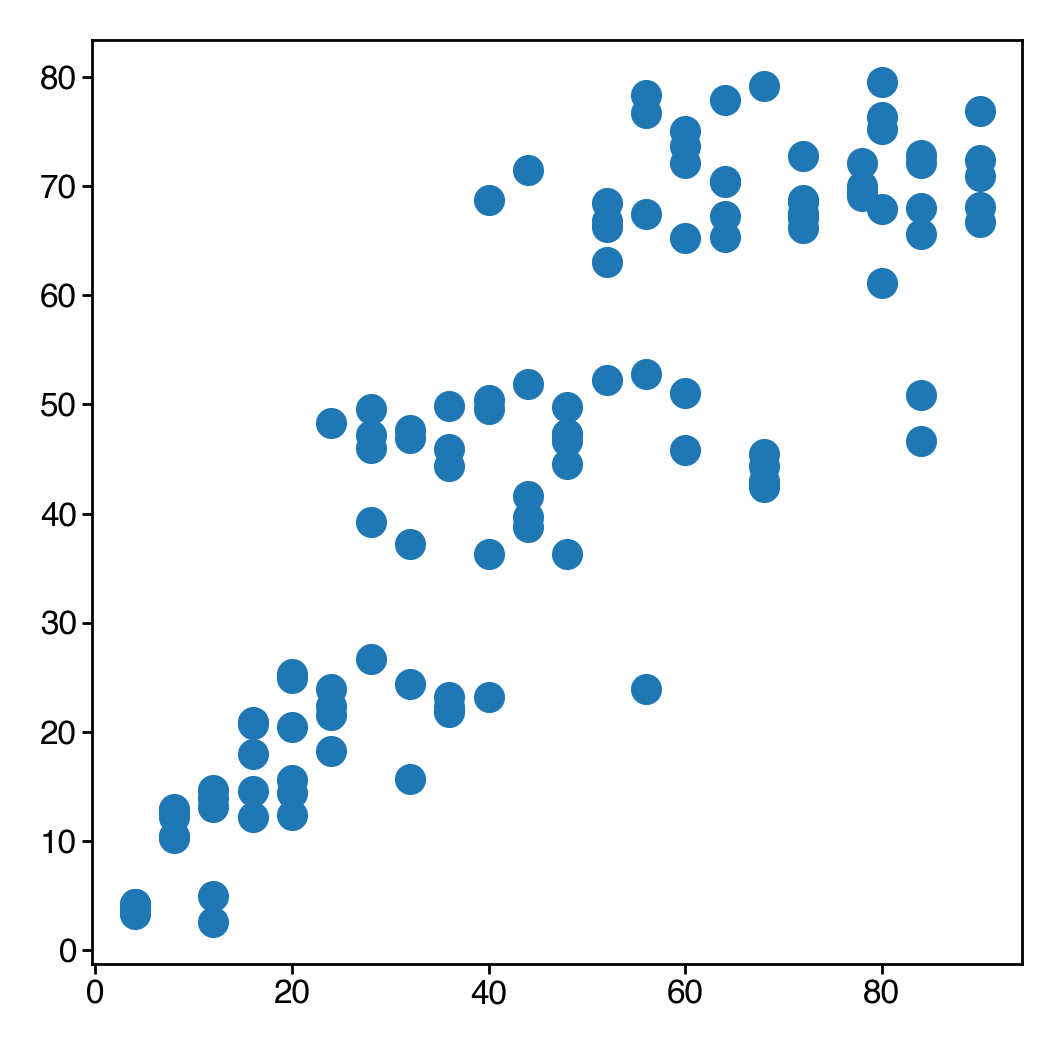

In [68]:
plt.scatter(tmp[0]['true_ages'], tmp[0]['bio_ages'])

In [77]:
hypparams["n_splines"] = 5
tmp = masked_xval(features, hypparams, 2, n_repeats=2, disable_tqdm=False)

  0%|          | 0/2 [00:00<?, ?it/s]

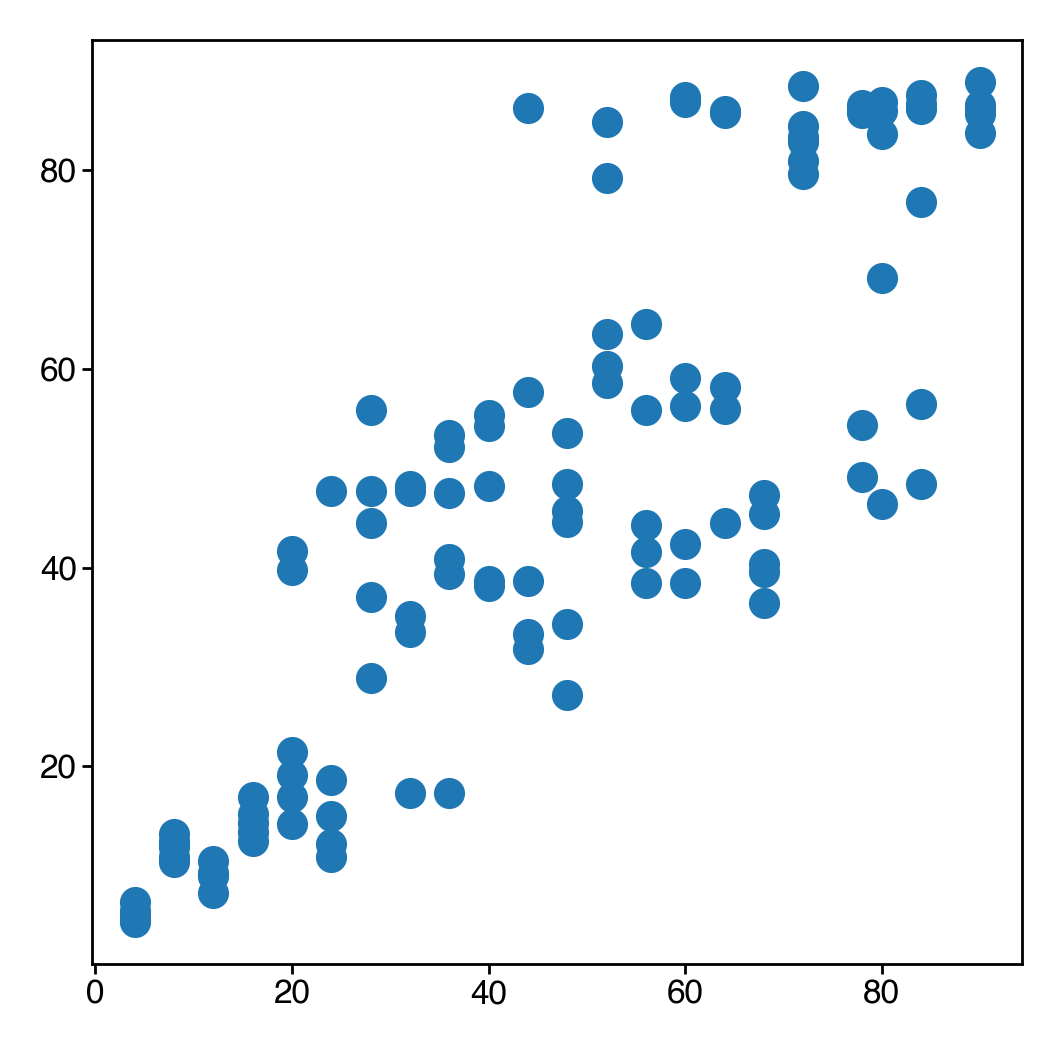

In [78]:
plt.scatter(tmp[0]['true_ages'], tmp[0]['bio_ages'])

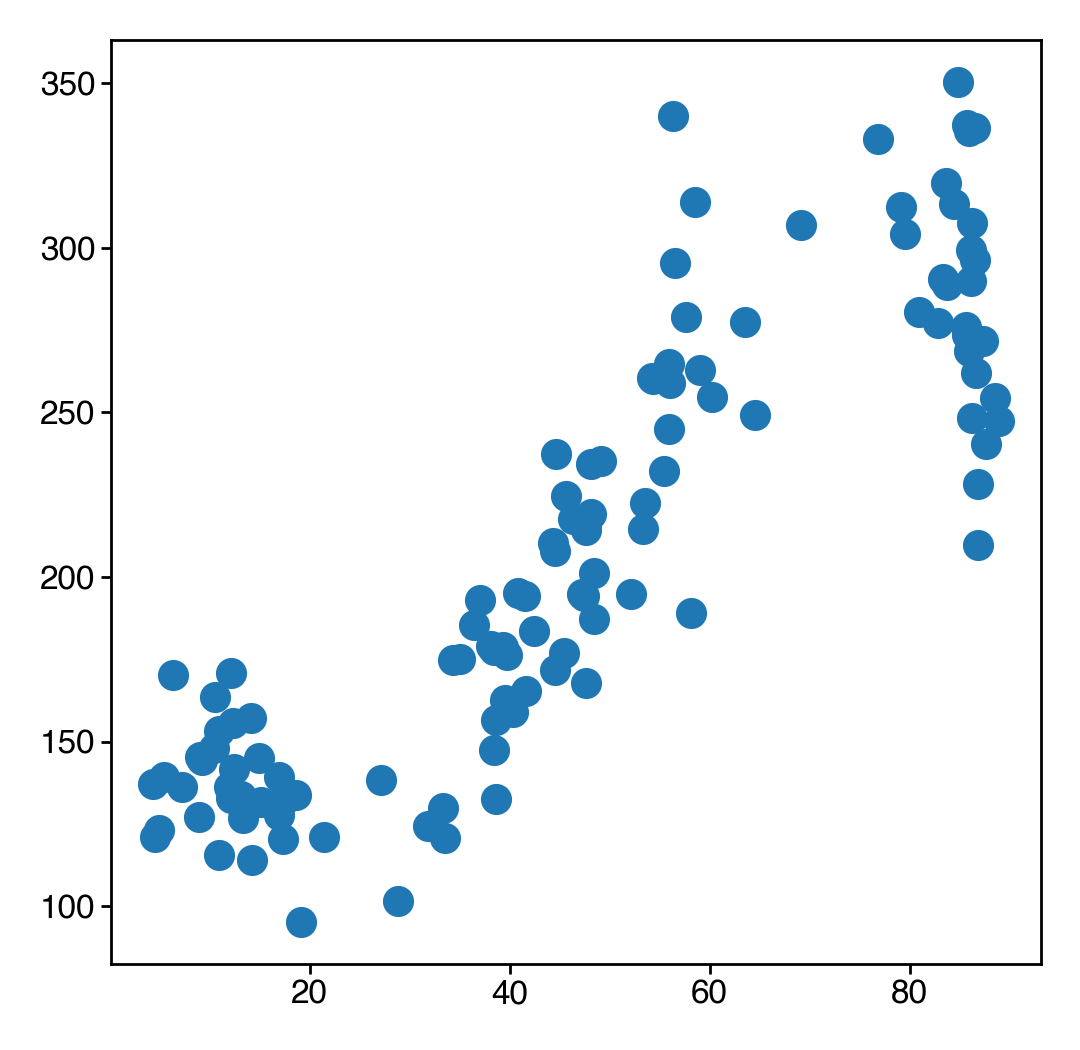

In [79]:
plt.scatter(tmp[0]['bio_ages'], tmp[0]['predicted_counts'][:, 0])

## Fit a "final" (lol) ontogeny model

In [86]:
features = {
    "ages": age,
    "counts": syllable_counts_jax + 1,
    "sizes": sizes_col.to_numpy(),
}

hypparams = {
    "min_age": 1,
    "max_age": 100,
    "age_sd": 7,  # weeks
    # "bio_params_sd": 3,
    "size_params_sd": 1000,
    "n_age_samples": 1000,
    "n_splines": 4,
    "n_size_splines": 5,
    "n_syllables": syllable_counts_jax.shape[1],
    "n_keep_sylls": 25,
    "n_sessions": len(syllable_counts_jax),
    "lr": 0.05,
    "n_opt_iter": 500,
    "use_rw_prior": False,
    "rw_sd": 100
}

In [87]:
tmp = masked_xval(features, hypparams, 2, n_repeats=10, disable_tqdm=False)

  0%|          | 0/10 [00:00<?, ?it/s]

In [88]:
!mkdir -p /n/scratch/users/w/wg41/bio-age-model/2024-04-11

/home/wg41/miniconda3/envs/aging-gpu/lib/python3.10/pty.py:89: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  pid, fd = os.forkpty()


In [90]:
for v in tmp.values():
    v["init_components"].age_normalizer = None
    v["init_components"].age_unnormalizer = None

In [91]:
joblib.dump(
    tmp,
    "/n/scratch/users/w/wg41/bio-age-model/2024-04-11/ontogeny-bio-age-model.p"
)

['/n/scratch/users/w/wg41/bio-age-model/2024-04-11/ontogeny-bio-age-model.p']

In [95]:
out_dict = {}
for k, v in tmp.items():
    out_dict[f'bio_age_{k:02d}'] = v['bio_ages']
out_dict['age'] = tmp[0]['true_ages']
bio_age_df = pd.DataFrame(out_dict, index=df.index)

In [97]:
bio_age_df.to_parquet("/n/scratch/users/w/wg41/bio-age-model/2024-04-11/ontogeny-bio-age-model.parquet")

### Version 2

In [98]:
features = {
    "ages": age,
    "counts": syllable_counts_jax + 1,
    "sizes": sizes_col.to_numpy(),
}

hypparams = {
    "min_age": 1,
    "max_age": 100,
    "age_sd": 20,  # weeks
    # "bio_params_sd": 3,
    "size_params_sd": 1000,
    "n_age_samples": 1000,
    "n_splines": 4,
    "n_size_splines": 5,
    "n_syllables": syllable_counts_jax.shape[1],
    "n_keep_sylls": 25,
    "n_sessions": len(syllable_counts_jax),
    "lr": 0.05,
    "n_opt_iter": 500,
    "use_rw_prior": False,
    "rw_sd": 100
}

In [100]:
tmp = masked_xval(features, hypparams, 2, n_repeats=6, disable_tqdm=False)

  0%|          | 0/6 [00:00<?, ?it/s]

In [101]:
for v in tmp.values():
    v["init_components"].age_normalizer = None
    v["init_components"].age_unnormalizer = None

In [102]:
joblib.dump(
    tmp,
    "/n/scratch/users/w/wg41/bio-age-model/2024-04-11/ontogeny-bio-age-model-v2.p"
)

['/n/scratch/users/w/wg41/bio-age-model/2024-04-11/ontogeny-bio-age-model-v2.p']

In [103]:
out_dict = {}
for k, v in tmp.items():
    out_dict[f'bio_age_{k:02d}'] = v['bio_ages']
out_dict['age'] = tmp[0]['true_ages']
bio_age_df = pd.DataFrame(out_dict, index=df.index)

In [104]:
bio_age_df.to_parquet("/n/scratch/users/w/wg41/bio-age-model/2024-04-11/ontogeny-bio-age-model-v2.parquet")

### Version 3 - 5 splines

In [5]:
features = {
    "ages": age,
    "counts": syllable_counts_jax + 1,
    "sizes": sizes_col.to_numpy(),
}

hypparams = {
    "min_age": 1,
    "max_age": 100,
    "age_sd": 20,  # weeks
    # "bio_params_sd": 3,
    "size_params_sd": 1000,
    "n_age_samples": 1000,
    "n_splines": 5,
    "n_size_splines": 5,
    "n_syllables": syllable_counts_jax.shape[1],
    "n_keep_sylls": 25,
    "n_sessions": len(syllable_counts_jax),
    "lr": 0.05,
    "n_opt_iter": 500,
    "use_rw_prior": False,
    "rw_sd": 100
}

In [6]:
tmp = masked_xval(features, hypparams, 2, n_repeats=6, disable_tqdm=False)

  0%|          | 0/6 [00:00<?, ?it/s]

In [7]:
for v in tmp.values():
    v["init_components"].age_normalizer = None
    v["init_components"].age_unnormalizer = None

In [8]:
joblib.dump(
    tmp,
    "/n/scratch/users/w/wg41/bio-age-model/2024-04-11/ontogeny-bio-age-model-v3.p"
)

['/n/scratch/users/w/wg41/bio-age-model/2024-04-11/ontogeny-bio-age-model-v3.p']

In [9]:
out_dict = {}
for k, v in tmp.items():
    out_dict[f'bio_age_{k:02d}'] = v['bio_ages']
out_dict['age'] = tmp[0]['true_ages']
bio_age_df = pd.DataFrame(out_dict, index=df.index)

In [10]:
bio_age_df.to_parquet("/n/scratch/users/w/wg41/bio-age-model/2024-04-11/ontogeny-bio-age-model-v3.parquet")

### Version 4 - 5 splines with bio params sd regularization

In [11]:
features = {
    "ages": age,
    "counts": syllable_counts_jax + 1,
    "sizes": sizes_col.to_numpy(),
}

hypparams = {
    "min_age": 1,
    "max_age": 100,
    "age_sd": 20,  # weeks
    "bio_params_sd": 3,
    "size_params_sd": 1000,
    "n_age_samples": 1000,
    "n_splines": 5,
    "n_size_splines": 5,
    "n_syllables": syllable_counts_jax.shape[1],
    "n_keep_sylls": 25,
    "n_sessions": len(syllable_counts_jax),
    "lr": 0.05,
    "n_opt_iter": 500,
    "use_rw_prior": False,
    "rw_sd": 100
}

In [12]:
tmp = masked_xval(features, hypparams, 2, n_repeats=6, disable_tqdm=False)

  0%|          | 0/6 [00:00<?, ?it/s]

In [13]:
for v in tmp.values():
    v["init_components"].age_normalizer = None
    v["init_components"].age_unnormalizer = None

In [14]:
joblib.dump(
    tmp,
    "/n/scratch/users/w/wg41/bio-age-model/2024-04-11/ontogeny-bio-age-model-v4.p"
)

['/n/scratch/users/w/wg41/bio-age-model/2024-04-11/ontogeny-bio-age-model-v4.p']

In [15]:
out_dict = {}
for k, v in tmp.items():
    out_dict[f'bio_age_{k:02d}'] = v['bio_ages']
out_dict['age'] = tmp[0]['true_ages']
bio_age_df = pd.DataFrame(out_dict, index=df.index)

In [16]:
bio_age_df.to_parquet("/n/scratch/users/w/wg41/bio-age-model/2024-04-11/ontogeny-bio-age-model-v4.parquet")

### Version 5 - 5 splines with bio params sd regularization and low `age_sd`

In [17]:
features = {
    "ages": age,
    "counts": syllable_counts_jax + 1,
    "sizes": sizes_col.to_numpy(),
}

hypparams = {
    "min_age": 1,
    "max_age": 100,
    "age_sd": 7,  # weeks
    "bio_params_sd": 3,
    "size_params_sd": 1000,
    "n_age_samples": 1000,
    "n_splines": 5,
    "n_size_splines": 5,
    "n_syllables": syllable_counts_jax.shape[1],
    "n_keep_sylls": 25,
    "n_sessions": len(syllable_counts_jax),
    "lr": 0.05,
    "n_opt_iter": 500,
    "use_rw_prior": False,
    "rw_sd": 100
}

In [18]:
tmp = masked_xval(features, hypparams, 2, n_repeats=6, disable_tqdm=False)

  0%|          | 0/6 [00:00<?, ?it/s]

In [19]:
for v in tmp.values():
    v["init_components"].age_normalizer = None
    v["init_components"].age_unnormalizer = None

In [20]:
joblib.dump(
    tmp,
    "/n/scratch/users/w/wg41/bio-age-model/2024-04-11/ontogeny-bio-age-model-v5.p"
)

['/n/scratch/users/w/wg41/bio-age-model/2024-04-11/ontogeny-bio-age-model-v5.p']

In [21]:
out_dict = {}
for k, v in tmp.items():
    out_dict[f'bio_age_{k:02d}'] = v['bio_ages']
out_dict['age'] = tmp[0]['true_ages']
bio_age_df = pd.DataFrame(out_dict, index=df.index)

In [22]:
bio_age_df.to_parquet("/n/scratch/users/w/wg41/bio-age-model/2024-04-11/ontogeny-bio-age-model-v5.parquet")